In [9]:
# Importing necessary libraries for analysis and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Setting seed for reproducibility
np.random.seed(42)

# --- 1. DIGITAL TWIN DATA SIMULATION ---
# Since real-time sensor data is sensitive, I am simulating a controlled environment
# representing 1000 hours of operation logs.

n_samples = 1000

# Generating sensor readings based on Normal Distribution
# Temperature (Kelvin): Normal operating range around 200K
temp_readings = np.random.normal(200, 50, n_samples)

# Pressure (Bar): System pressure readings
pressure_readings = np.random.normal(10, 2, n_samples)

# Vibration (mm): Mechanical vibrations
vibration_readings = np.random.normal(0.05, 0.02, n_samples)

# Creating the DataFrame (The Log Table)
df = pd.DataFrame({
    'Sensor_Temp_K': temp_readings,
    'Sensor_Pressure_Bar': pressure_readings,
    'Sensor_Vibration_mm': vibration_readings
})

# Quick inspection of the synthetic data
print("Shape of the simulated dataset:", df.shape)
display(df.head())

Shape of the simulated dataset: (1000, 3)


,Sensor_Temp_K,Sensor_Pressure_Bar,Sensor_Vibration_mm
0,224.835708,12.798711,0.036496
1,193.086785,11.849267,0.047110
2,232.384427,10.119261,0.034152
3,276.151493,8.706126,0.043841
4,188.292331,11.396447,0.012128


In [10]:
import random

# Initialize system status
df['Status'] = 0

# --- CRITICAL THRESHOLDS DEFINITION ---
# Physical operating limits derived from system specifications.
THRESHOLD_TEMP = 280
THRESHOLD_PRESSURE = 13
THRESHOLD_VIBRATION = 0.08

# Applying deterministic failure logic
failure_conditions = (
    (df['Sensor_Temp_K'] > THRESHOLD_TEMP) |
    ((df['Sensor_Pressure_Bar'] > THRESHOLD_PRESSURE) & (df['Sensor_Vibration_mm'] > THRESHOLD_VIBRATION))
)

df.loc[failure_conditions, 'Status'] = 1

# --- ROBUSTNESS VERIFICATION MODULE ---
# Injecting stochastic sensor noise (5%) to evaluate model performance under non-ideal conditions.
# Purpose: Prevent overfitting and validate classifier stability.

NOISE_FACTOR = 0.05
target_indices = random.sample(list(df.index), int(n_samples * NOISE_FACTOR))

for idx in target_indices:
    # Invert binary status signal for stress testing
    df.loc[idx, 'Status'] = 1 - df.loc[idx, 'Status']

# Output distribution check
print(f"System Status Distribution (Noise Factor: {NOISE_FACTOR}):")
print(df['Status'].value_counts())

System Status Distribution (Noise Factor: 0.05):
Status
0    892
1    108
Name: count, dtype: int64


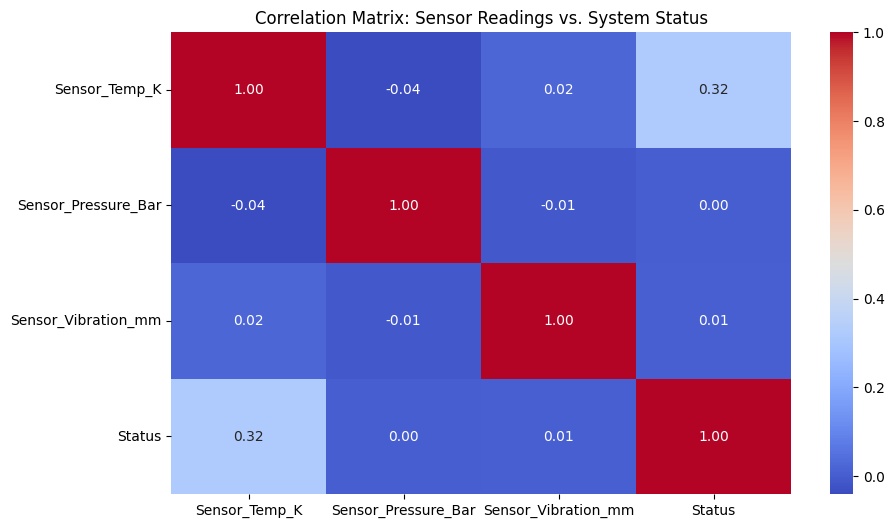

In [11]:
# --- 3. CORRELATION ANALYSIS ---
# Checking correlation to understand relationships between sensors and failure status.

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix: Sensor Readings vs. System Status")
plt.show()

Model training complete.



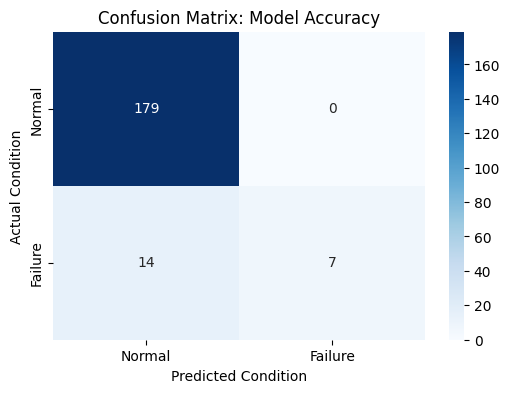

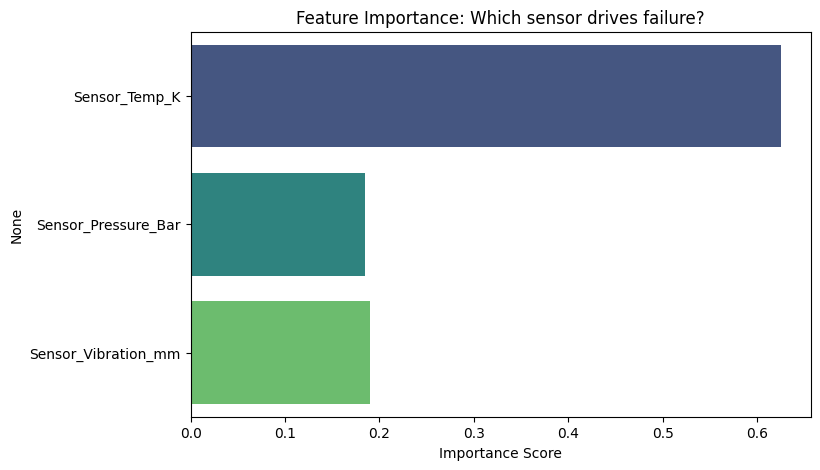

In [12]:
# --- 4. MODEL TRAINING (Random Forest) ---

# Defining Features (X) and Target (y)
X = df.drop('Status', axis=1)
y = df['Status']

# Splitting dataset: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Random Forest Classifier
# Why? It handles non-linear relationships well and provides feature importance.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Making predictions
y_pred = rf_model.predict(X_test)

print("Model training complete.\n")

# --- 5. PERFORMANCE EVALUATION ---

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
labels = ['Normal', 'Failure']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Model Accuracy")
plt.ylabel('Actual Condition')
plt.xlabel('Predicted Condition')
plt.show()

# Feature Importance Analysis
# Did the model correctly identify Temperature as the main stress factor?
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='viridis', hue=feature_names, legend=False)
plt.title("Feature Importance: Which sensor drives failure?")
plt.xlabel("Importance Score")
plt.show()